In [1]:
import pandas as pd
import numpy as np
import csv
from DeepSvDDClass import *
import torch

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [10]:
#don't use validation dataset since there is no overfitting in svdd?
def train_test(deepsvdd_datapath = None, split_ratio:float = 0.2):
    deepsvdd_data_csv = pd.read_csv(deepsvdd_datapath)
    
    #train data only needs normal data, test data need normal and abnormal data
    data_normal = deepsvdd_data_csv[(deepsvdd_data_csv["normal/abnormal"] == "normal" )]
    data_abnormal = deepsvdd_data_csv[(deepsvdd_data_csv["normal/abnormal"] == "abnormal" )]
    
    data_normal.loc[data_normal["normal/abnormal"] == "normal", "normal/abnormal"] = 1
    
    data_abnormal.loc[data_abnormal["normal/abnormal"] == "normal", "normal/abnormal"] = 1
    data_abnormal.loc[data_abnormal["normal/abnormal"] == "abnormal", "normal/abnormal"] = -1


    train_dataset_normal, test_dataset_normal  = train_test_split(data_normal, test_size=split_ratio, shuffle = False)
    
    train_dataset = train_dataset_normal
    test_dataset = pd.concat([test_dataset_normal, data_abnormal])
    
    return shuffle(train_dataset), shuffle(test_dataset)


datapath = r'C:\Users\brech\THESIS_local\ToyADMOS\DeepSVDD_case1_ch1.csv'
X_train, X_test = train_test(deepsvdd_datapath = datapath, split_ratio=0.2)

In [8]:
X_test

,normal/abnormal,rms,zcr,kurtosis,skewness,std,CF,SF,IF,CLF,centroid,entropy
1523,-1,0.070673,0.138653,8.074139,-0.346495,0.070673,14.149678,1.541820,21.816256,28.708416,1725.792269,0.839830
1600,-1,0.116782,0.108251,3.334718,-0.005256,0.116782,8.562998,1.394888,11.944422,14.833843,1684.036483,0.787546
1415,-1,0.089126,0.127866,7.499137,-0.198247,0.089126,11.220128,1.486888,16.683077,21.256041,1749.703900,0.810626
1246,1,0.128590,0.126031,0.886327,0.001081,0.128590,7.776651,1.300829,10.116095,12.191249,1844.903994,0.805001
1213,1,0.092816,0.125511,1.208774,-0.046710,0.092816,10.773992,1.307681,14.088943,17.008516,1807.500607,0.784701
...,...,...,...,...,...,...,...,...,...,...,...,...
1252,1,0.149446,0.123508,0.704267,-0.029812,0.149446,6.691400,1.283828,8.590610,10.256365,1786.888129,0.807063
1110,1,0.144014,0.125011,1.201488,-0.021285,0.144014,6.943764,1.317252,9.146686,11.102371,1779.052458,0.791210
1186,1,0.141125,0.152618,0.744396,-0.035389,0.141125,7.085911,1.291644,9.152472,10.975108,2054.727372,0.819820
1571,-1,0.222853,0.068848,0.240876,-0.004636,0.222853,4.487259,1.269691,5.697433,6.780417,1308.930025,0.521969


In [11]:
#target values y: 1 for positive(normal) and -1 for negative sample
Y_train_numpy = X_train["normal/abnormal"].to_numpy().reshape(-1, 1) #dimension is now (1080,1) instead of (1080,)
Y_test_numpy = X_test["normal/abnormal"].to_numpy().reshape(-1, 1) #dimension is now (1080,1) instead of (1080,)

#drop column of norm/abnorm, so train and test are only filled with the feature values
X_train = X_train.drop(columns=["normal/abnormal"])
X_test = X_test.drop(columns=["normal/abnormal"])

X_train_numpy = X_train.to_numpy() 
X_test_numpy = X_test.to_numpy()

print("X_train shape:" , X_train_numpy.shape,"\n",
      "X_test shape", X_test_numpy.shape,"\n",
      "Y_train shape:", Y_train_numpy.shape,"\n",
      "Y_test shape:", Y_test_numpy.shape)

X_train shape: (1080, 11) 
 X_test shape (534, 11) 
 Y_train shape: (1080, 1) 
 Y_test shape: (534, 1)


In [16]:
#using example 2 from https://github.com/iqiukp/SVDD-Python
X_train_numpy = X_train_numpy.astype(np.double) #cvxopt does not support ints, only doubles
X_test_numpy = X_test_numpy.astype(np.double) 
Y_train_numpy = Y_train_numpy.astype(np.double) 
Y_test_numpy = Y_test_numpy.astype(np.double) 

svdd = BaseSVDD(C = 0.1, gamma =  0.01, kernel =  'rbf')
svdd.fit(X_train_numpy,  Y_train_numpy)
y_test_predict = svdd.predict(X_test_numpy, Y_test_numpy)

#svdd = BaseSVDD(C = 0.1, degree =  2, kernel =  'poly') #52.06 percent accuracy
#svdd = BaseSVDD(C = 0.1, degree =  4, kernel =  'poly') #55.05 percent accuracy
#svdd = BaseSVDD(C = 0.5, degree =  5, kernel =  'poly') #58.05

#svdd = BaseSVDD(C = 0.1, gamma=0.3, kernel='linear')  #50.56 percent accuracy


#svdd = BaseSVDD(C = 0.1, gamma =  0.1, kernel =  'rbf')  #75.84 percent accuracy  
#svdd = BaseSVDD(C = 0.1, gamma =  0.01, kernel =  'rbf') #82 percent accuracy <<======= AUC curve lower than the one above?

#svdd = BaseSVDD(C = 0.1, gamma =  0.2, kernel =  'rbf')  #69.10 percent accuracy
#svdd = BaseSVDD(C = 0.1, gamma =  0.5, kernel =  'rbf')  #61.23 percent accuracy

#svdd = BaseSVDD(C = 0.5, gamma =  0.1, kernel =  'rbf')  #75.46 percent accuracy
#svdd = BaseSVDD(C = 1,   gamma =  0.1, kernel =  'rbf')  #75.28 percent accuracy





*** Fitting of the SVDD model is completed. ***

running time         = 1.2930 seconds
kernel function      = rbf
iterations           = 13
number of samples    = 1080
number of features   = 11
number of SVs        = 156
ratio of SVs         = 14.4444 %
accuracy             = 87.5926 %




*** Prediction of the provided data is completed. ***

running time         = 0.0210 seconds
number of samples    = 534
number of alarm      = 241
accuracy             = 82.5843 %




In [ ]:
#figure out which comibination gives the best results
from sklearn.model_selection import learning_curve, GridSearchCV

param_grid = [
    {"kernel": ["rbf"], "gamma": [0.1, 0.2, 0.5], "C": [0.1, 0.5, 1]},
    {"kernel": ["linear"], "C": [0.1, 0.5, 1]},
    {"kernel": ["poly"], "C": [0.1, 0.5, 1], "degree": [2, 3, 4, 5]},
]

svdd = GridSearchCV(BaseSVDD(display='off'), param_grid, cv=5, scoring="accuracy")
svdd.fit(X_train_numpy, Y_train_numpy)
print("best parameters:")
print(svdd.best_params_)
print("\n")

# 
best_model = svdd.best_estimator_
means = svdd.cv_results_["mean_test_score"]
stds = svdd.cv_results_["std_test_score"]

for mean, std, params in zip(means, stds, svdd.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

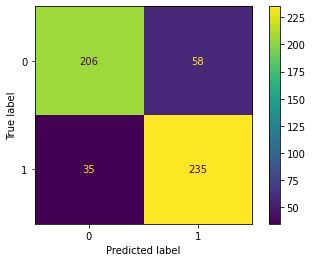

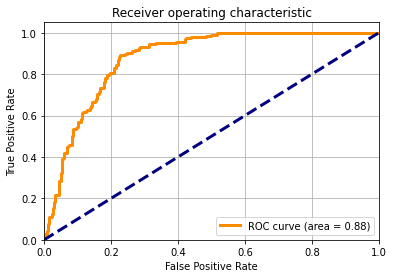

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# confusion matrix and ROC curve
cm = confusion_matrix(Y_test_numpy, y_test_predict)
cm_display = ConfusionMatrixDisplay(cm).plot()
y_score = svdd.decision_function(X_test_numpy)

fpr, tpr, _ = roc_curve(Y_test_numpy, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=3, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [9]:
"""In the basic approach of k-fold CV, the training set is split into k smaller sets.
The following procedure is followed for each of the k “folds”:
    1) A model is trained using k-1 of the folds as training data;
    2) The resulting model is validated on the remaining part of the data 
    (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. 
"""
#https://scikit-learn.org/stable/modules/cross_validation.html
#cross validation
from sklearn.model_selection import cross_val_score

svdd = BaseSVDD(C = 0.1, gamma =  0.01, kernel =  'rbf')

# cross validation (k-fold)
k = 5
scores = cross_val_score(svdd, X_train_numpy, Y_train_numpy, cv=k, scoring='accuracy')

#
print("Cross validation scores:")
for scores_ in scores:
    print(scores_)
 
print("Mean cross validation score: {:4f}".format(scores.mean()))



*** Fitting of the SVDD model is completed. ***

running time         = 0.6077 seconds
kernel function      = rbf
iterations           = 12
number of samples    = 864
number of features   = 11
number of SVs        = 145
ratio of SVs         = 16.7824 %
accuracy             = 84.4907 %




*** Prediction of the provided data is completed. ***

running time         = 0.0090 seconds
number of samples    = 216
number of alarm      = 44




*** Fitting of the SVDD model is completed. ***

running time         = 0.6520 seconds
kernel function      = rbf
iterations           = 13
number of samples    = 864
number of features   = 11
number of SVs        = 156
ratio of SVs         = 18.0556 %
accuracy             = 84.6065 %




*** Prediction of the provided data is completed. ***

running time         = 0.0070 seconds
number of samples    = 216
number of alarm      = 23




*** Fitting of the SVDD model is completed. ***

running time         = 0.6580 seconds
kernel function      = rbf
iter